## Random forest classification

### Imports and global variables

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import *
from IPython.display import display
from sklearn.metrics import roc_curve, auc

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

plt.style.use('fivethirtyeight')
%matplotlib inline

path = '/Users/katbishop/Desktop/DSI-SF2-bishopkd/projects/capstone/data/'

#### Load the data

In [19]:
# load training data
df = pd.read_csv(path + 'df.csv')
del df['Unnamed: 0']
#del df['Unnamed: 0.1']

# load held-out testing data
df_test = pd.read_csv(path + 'df_test.csv')
del df_test['Unnamed: 0']

df_all = pd.concat([df,df_test], axis=0).reset_index()
del df_all['index']

print df.shape
print df_test.shape
print df_all.shape
df_all.head(2)

(78, 64)
(14, 64)
(92, 64)


,adj,adj_compare,adj_sup,adv,adv_compare,adv_part,adv_sup,avg_sent_len,avg_word_len,best_seller,...,verb_count,verb_ger,verb_past,verb_pp,verb_sing_pres,wh_adv,wh_determ,wh_poss,wh_pronoun,word_count
0,0.069588,0.003314,0.002129,0.063591,0.001534,0.006965,0.000265,14,4,1,...,29612.0,0.023553,0.070598,0.023559,0.019427,0.005545,0.004228,0.000024,0.004685,166265
1,0.065146,0.004336,0.003233,0.067069,0.002154,0.005526,0.000405,11,4,1,...,36339.0,0.019928,0.078151,0.024544,0.015360,0.004794,0.003826,0.000043,0.004250,207548


In [20]:
# subset the data
sf = df_all[df_all['sci_fi']==1]
rm = df_all[df_all['sci_fi']==0]
print sf.shape
print rm.shape

(47, 64)
(45, 64)


In [52]:
rm.best_seller.mean()

0.4888888888888889

#### Science-fiction

In [18]:
y_sf = sf['best_seller']
X_sf = sf[['avg_sent_len', 'avg_word_len', 'lex_diversity', 'polarity','subjectivity', 'profane','conj_coord',
            'determiner', 'exist_there', 'foreign_word','conj_sub_prep', 'adj', 'adj_compare','adj_sup', 
           'verb_aux','noun', 'noun_prop', 'noun_prop_pural', 'noun_plural', 'predeterm','poss_ending','pronoun_pers',
           'pronoun_poss', 'adv', 'adv_compare','adv_sup', 'adv_part', 'inf_to', 'interject', 'verb_base','verb_past',
           'verb_ger', 'verb_pp', 'verb_sing_pres','verb_3rd_sing_pres', 'wh_determ', 'wh_pronoun', 'wh_poss','wh_adv',
           'verb.body', 'verb.change', 'verb.cognition','verb.communication', 'verb.competition', 'verb.consumption',
           'verb.contact', 'verb.creation', 'verb.emotion', 'verb.motion','verb.perception', 'verb.possession', 
           'verb.social', 'verb.stative','verb.weather']]

print y_sf.shape, X_sf.shape

(47,) (47, 54)


In [22]:
X_sf, X_sf_test, y_sf, y_sf_test = train_test_split(X_sf, y_sf, test_size=0.3)

print X_sf.shape, y_sf.shape
print X_sf_test.shape, y_sf_test.shape

(32, 54) (32,)
(15, 54) (15,)


#### Random Forest Classifier

In [439]:
rfc = RandomForestClassifier()
rf_params = {
    'max_features':['log2','sqrt', 2,3,4,5],
    'max_depth':[1,2,3,4],
    'min_samples_leaf':np.linspace(1,30,20),
    'n_estimators':[50]
}

rf_gs_sf = GridSearchCV(rfc, rf_params, cv=5, verbose=1, n_jobs=-1)
rf_model_sf = rf_gs_sf.fit(X_sf, y_sf) 

rf_proba_sf = rf_model_sf.predict_log_proba(X_sf_test)
y_sf_pp = rf_model_sf.predict_log_proba(X_sf_test)[:,1]

rfc_best_sf = rf_gs_sf.best_estimator_
print "best estimator", rfc_best_sf
print 
print "best parameters",  rf_gs_sf.best_params_
print 
print "best score", rf_gs_sf.best_score_

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:  3.3min finished


best estimator RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1.0, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

best parameters {'max_features': 'sqrt', 'n_estimators': 50, 'max_depth': 4, 'min_samples_leaf': 1.0}

best score 0.875


In [437]:
## Print Feature importances
feature_importance = pd.DataFrame({ 'feature':X_sf.columns, 
                                   'importance':rfc_best_sf.feature_importances_
                                  })

feature_importance.sort_values('importance', ascending=False, inplace=True)
feature_importance.head(10)

,feature,importance
9,foreign_word,0.571816
2,lex_diversity,0.247360
29,verb_base,0.115490
15,noun,0.065334
0,avg_sent_len,0.000000
41,verb.cognition,0.000000
31,verb_ger,0.000000
32,verb_pp,0.000000
33,verb_sing_pres,0.000000
34,verb_3rd_sing_pres,0.000000


In [30]:
feature_importance.tail(2)

,feature,importance
5,profane,0.0
53,verb.weather,0.0


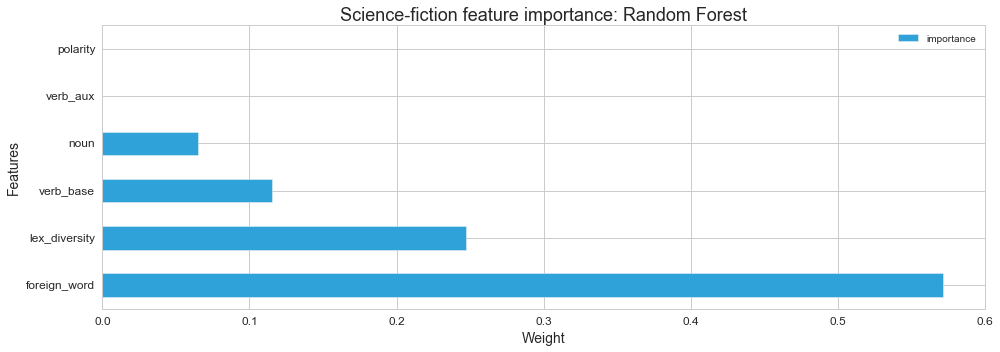

In [483]:
feat = feature_importance.set_index('feature')
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
bar_width = 0.35
feat.sort_values('importance', ascending=0).head(6).plot(kind='barh', figsize=(14,5),fontsize=12)
plt.xlabel('Weight',fontsize=14)
plt.ylabel('Features',fontsize=14)
plt.title('Science-fiction feature importance: Random Forest',fontsize=18)
plt.tight_layout()
plt.show()

In [484]:
y_sf_pred_rfc= rfc_best.predict(X_sf_test)

print y_sf_pred_rfc.shape, y_sf_test.shape

cls_rep = classification_report(y_sf_test, y_sf_pred_rfc)
print cls_rep 

(15,) (15,)
             precision    recall  f1-score   support

          0       0.62      0.83      0.71         6
          1       0.86      0.67      0.75         9

avg / total       0.76      0.73      0.74        15



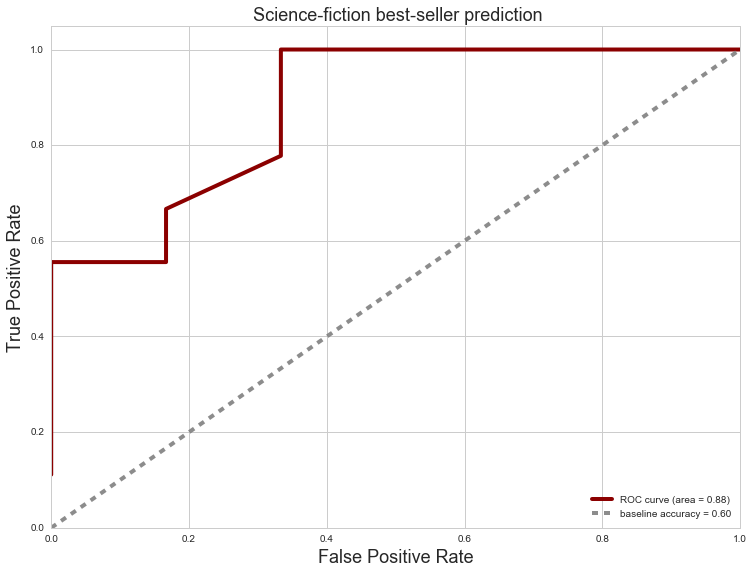

In [487]:
plot_roc_curve(target=y_sf_test, predict_proba=rf_proba_sf[:,1], title='Science-fiction best-seller prediction')

#### Romance

In [515]:
y_rm = rm['best_seller']
X_rm = rm[['avg_sent_len', 'avg_word_len', 'lex_diversity', 'polarity','subjectivity', 'profane','conj_coord',
            'determiner', 'exist_there', 'foreign_word','conj_sub_prep', 'adj', 'adj_compare','adj_sup', 
           'verb_aux','noun', 'noun_prop', 'noun_prop_pural', 'noun_plural', 'predeterm','poss_ending','pronoun_pers',
           'pronoun_poss', 'adv', 'adv_compare','adv_sup', 'adv_part', 'inf_to', 'interject', 'verb_base','verb_past',
           'verb_ger', 'verb_pp', 'verb_sing_pres','verb_3rd_sing_pres', 'wh_determ', 'wh_pronoun', 'wh_poss','wh_adv',
           'verb.body', 'verb.change', 'verb.cognition','verb.communication', 'verb.competition', 'verb.consumption',
           'verb.contact', 'verb.creation', 'verb.emotion', 'verb.motion','verb.perception', 'verb.possession', 
           'verb.social', 'verb.stative','verb.weather']]


print y_rm.shape, X_rm.shape

(45,) (45, 54)


In [516]:
X_rm, X_rm_test, y_rm, y_rm_test = train_test_split(X_rm, y_rm, test_size=0.3)

print X_rm.shape, y_rm.shape
print X_rm_test.shape, y_rm_test.shape

(31, 54) (31,)
(14, 54) (14,)


In [517]:
rfc = RandomForestClassifier()
rf_params = {
    'max_features':['log2','sqrt', 2,3,4,5],
    'max_depth':[1,2,3,4],
    'min_samples_leaf':np.linspace(1,20,10),
    'n_estimators':[100]
}

rf_gs_rm = GridSearchCV(rfc, rf_params, cv=5, verbose=1, n_jobs=-1)
rf_model_rm = rf_gs_rm.fit(X_rm, y_rm) 

rf_proba_rm = rf_model_rm.predict_log_proba(X_rm_test)

rfc_best_rm = rf_gs_rm.best_estimator_

print "best estimator", rfc_best_rm
print 
print "best parameters",  rf_gs_rm.best_params_
print 
print "best score", rf_gs_rm.best_score_

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  2.8min finished


best estimator RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='log2', max_leaf_nodes=None,
            min_samples_leaf=1.0, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

best parameters {'max_features': 'log2', 'n_estimators': 100, 'max_depth': 4, 'min_samples_leaf': 1.0}

best score 0.806451612903


In [518]:
## Print Feature importances
feature_importance = pd.DataFrame({ 'feature':X_rm.columns, 
                                   'importance':rfc_best_rm.feature_importances_
                                  })

feature_importance.sort_values('importance', ascending=False, inplace=True)
feature_importance.head(10)

,feature,importance
15,noun,0.043884
30,verb_past,0.043176
31,verb_ger,0.041578
2,lex_diversity,0.040854
23,adv,0.034814
49,verb.perception,0.034254
35,wh_determ,0.033237
46,verb.creation,0.030085
7,determiner,0.029910
14,verb_aux,0.028765


In [496]:
feature_importance.tail(2)

,feature,importance
5,profane,0.0
53,verb.weather,0.0


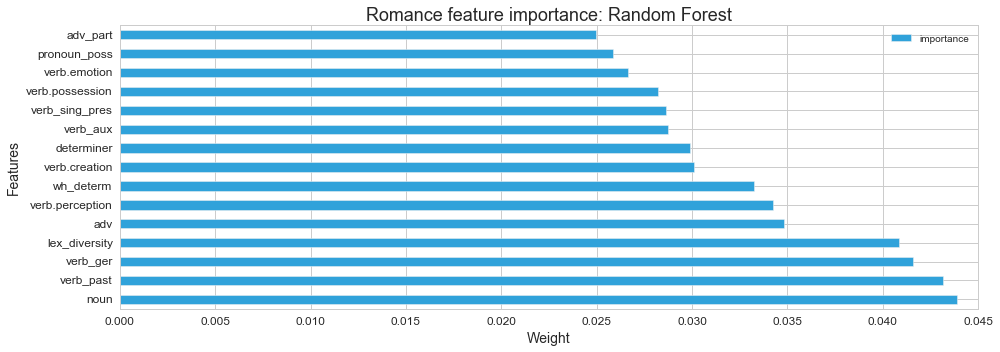

In [519]:
feat_rm = feature_importance.set_index('feature')
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
bar_width = 0.35
feat_rm.sort_values('importance', ascending=0).head(15).plot(kind='barh', figsize=(14,5),fontsize=12)
plt.xlabel('Weight',fontsize=14)
plt.ylabel('Features',fontsize=14)
plt.title('Romance feature importance: Random Forest',fontsize=18)
plt.tight_layout()
plt.show()

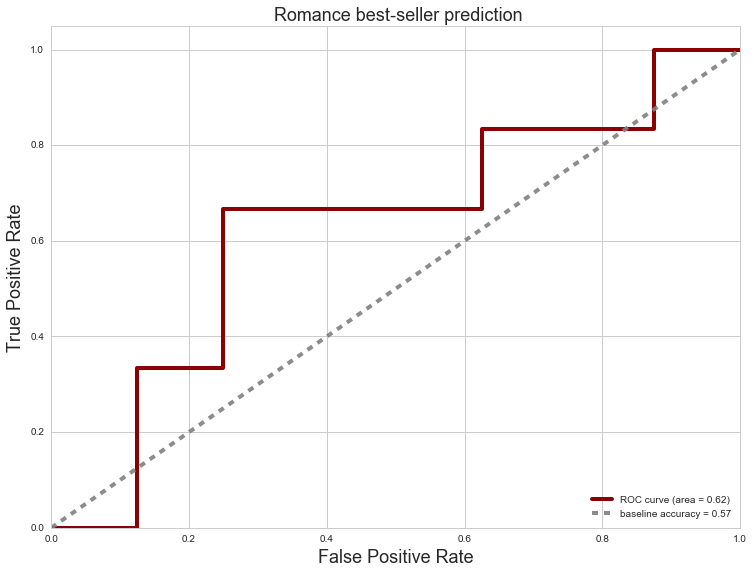

In [522]:
plot_roc_curve(target=y_rm_test, predict_proba=rf_proba_rm[:,1], title='Romance best-seller prediction')

## Best-seller predictor

In [176]:
def predict_8ball(mod, X_test, title):
    df = pd.DataFrame(['best_seller','probability','title'])
    i=0
    y_other_pred = mod.predict(X_test)
    proba_other = mod.predict_proba(X_test)
    for y, p, t in zip(y_other_pred, proba_other, title):
        if y==1:
            df.ix[i,'best_seller'] = 'best seller'
            df.ix[i,'probability'] = p[1]
        else:
            df.ix[i,'best_seller'] = 'flop'
            df.ix[i,'probability'] = p[0]
        df.ix[i,'title'] = t
        i+=1
    del df[0]
    return df.sort_values(['best_seller','probability'],ascending=[True,False])


In [422]:
df_other = pd.read_csv(path + 'df_other.csv')
del df_other['Unnamed: 0']

y_other = df_other['best_seller']
X_other = df_other[['avg_sent_len', 'avg_word_len', 'lex_diversity', 'polarity','subjectivity', 'profane','conj_coord',
            'determiner', 'exist_there', 'foreign_word','conj_sub_prep', 'adj', 'adj_compare','adj_sup', 
           'verb_aux','noun', 'noun_prop', 'noun_prop_pural', 'noun_plural', 'predeterm','poss_ending','pronoun_pers',
           'pronoun_poss', 'adv', 'adv_compare','adv_sup', 'adv_part', 'inf_to', 'interject', 'verb_base','verb_past',
           'verb_ger', 'verb_pp', 'verb_sing_pres','verb_3rd_sing_pres', 'wh_determ', 'wh_pronoun', 'wh_poss','wh_adv',
           'verb.body', 'verb.change', 'verb.cognition','verb.communication', 'verb.competition', 'verb.consumption',
           'verb.contact', 'verb.creation', 'verb.emotion', 'verb.motion','verb.perception', 'verb.possession', 
           'verb.social', 'verb.stative','verb.weather']]


In [423]:
predict_8ball(rf_model_rm, X_other,df_other['title'])

,best_seller,probability,title
0,best seller,0.630054,a plate of wheat for three blind tigers - jane...
1,best seller,0.525166,amish vampires in space - kerry nietz
3,flop,0.579429,stark pleasure - cathryn cade
2,flop,0.543657,aquarian awakenings - lisa shea


In [177]:
print sf.shape

y_all = sf['best_seller']
X_all = sf[['avg_sent_len', 'avg_word_len', 'lex_diversity', 'polarity','subjectivity', 'profane','conj_coord',
            'determiner', 'exist_there', 'foreign_word','conj_sub_prep', 'adj', 'adj_compare','adj_sup', 
           'verb_aux','noun', 'noun_prop', 'noun_prop_pural', 'noun_plural', 'predeterm','poss_ending','pronoun_pers',
           'pronoun_poss', 'adv', 'adv_compare','adv_sup', 'adv_part', 'inf_to', 'interject', 'verb_base','verb_past',
           'verb_ger', 'verb_pp', 'verb_sing_pres','verb_3rd_sing_pres', 'wh_determ', 'wh_pronoun', 'wh_poss','wh_adv',
           'verb.body', 'verb.change', 'verb.cognition','verb.communication', 'verb.competition', 'verb.consumption',
           'verb.contact', 'verb.creation', 'verb.emotion', 'verb.motion','verb.perception', 'verb.possession', 
           'verb.social', 'verb.stative','verb.weather']]

results = predict_8ball(rf_model_sf, X_all, sf['title'])
results

(47, 64)


,best_seller,probability,title
12,best seller,0.859846,rainbows end - vernor vinge
14,best seller,0.846921,snow crash - neal stephenson
17,best seller,0.835634,the left hand of darkness - ursula leguin
40,best seller,0.785081,dune messiah - frank herbert
11,best seller,0.756748,neuromancer - gibson william
0,best seller,0.753611,2312 - kim stanley robinson
16,best seller,0.734042,the forever war - joe haldeman
15,best seller,0.728911,the algebraist - iain m banks
5,best seller,0.723228,diamond age - neal stephenson
7,best seller,0.718014,dune - frank herbert


In [178]:
y_all = rm['best_seller']
X_all = rm[['avg_sent_len', 'avg_word_len', 'lex_diversity', 'polarity','subjectivity', 'profane','conj_coord',
            'determiner', 'exist_there', 'foreign_word','conj_sub_prep', 'adj', 'adj_compare','adj_sup', 
           'verb_aux','noun', 'noun_prop', 'noun_prop_pural', 'noun_plural', 'predeterm','poss_ending','pronoun_pers',
           'pronoun_poss', 'adv', 'adv_compare','adv_sup', 'adv_part', 'inf_to', 'interject', 'verb_base','verb_past',
           'verb_ger', 'verb_pp', 'verb_sing_pres','verb_3rd_sing_pres', 'wh_determ', 'wh_pronoun', 'wh_poss','wh_adv',
           'verb.body', 'verb.change', 'verb.cognition','verb.communication', 'verb.competition', 'verb.consumption',
           'verb.contact', 'verb.creation', 'verb.emotion', 'verb.motion','verb.perception', 'verb.possession', 
           'verb.social', 'verb.stative','verb.weather']]

results = predict_8ball(rf_model_rm, X_all, rm['title'])
results

,best_seller,probability,title
4,best seller,0.684552,brokedown cowboy - maisey yates
41,best seller,0.669921,see me - nicholas sparks
11,best seller,0.664888,one wish - robyn carr
19,best seller,0.635656,a heart too proud - laura london
9,best seller,0.632340,love letters - debbie macomber
10,best seller,0.628890,love story - erich segal
0,best seller,0.625047,a new hope - robyn carr
18,best seller,0.622076,the wedding pact - katee robert
39,best seller,0.618952,baby its you - jane graves
1,best seller,0.610891,a walk to remember - nicolas sparks


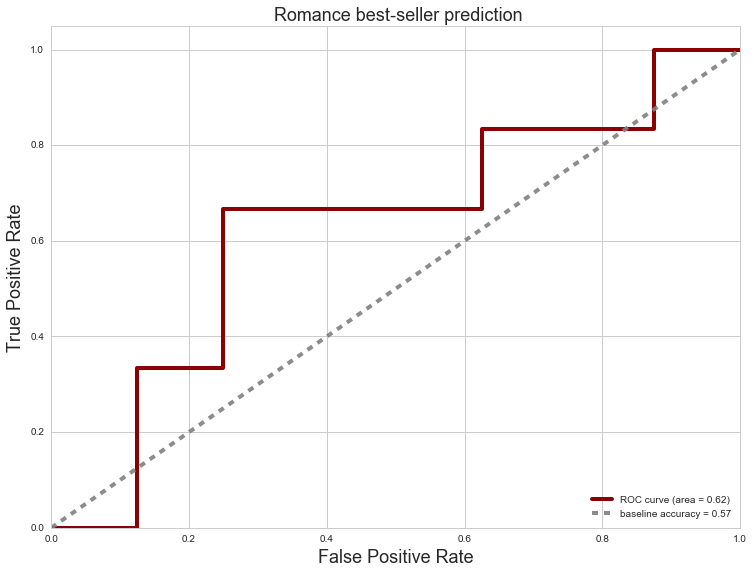

In [526]:
plot_roc_curve(target=y_rm_test, predict_proba=rf_proba_rm[:,1], title='Romance best-seller prediction')

In [486]:
def plot_roc_curve(target=False, predict_proba=False, title='Your prediction'):

    FPR = dict()
    TPR = dict()
    ROC_AUC = dict()

    FPR[1], TPR[1], _ = roc_curve(target,predict_proba)
    ROC_AUC[1] = auc(FPR[1], TPR[1])
    acc_ = np.abs(0.5 - np.mean(target)) + 0.5

    plt.figure(figsize=[11,9])
    plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4, color='darkred')
    #plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.plot([0, 1], [0, 1], color='grey', ls='dashed',
             alpha=0.9, linewidth=4, label='baseline accuracy = %0.2f' % acc_)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title(' %s' % title, fontsize=18)
    plt.legend(loc="lower right")
    plt.show()

In [85]:
def plot_roc(mod, X, X_test,y,y_test, varname):
    mod.fit(X, y)
    y_pp = mod.predict_log_proba(X_test)[:, 1]
    fpr_, tpr_, _ = roc_curve(y_test, y_pp)
    auc_ = auc(fpr_, tpr_)
    acc_ = np.abs(0.5 - np.mean(y)) + 0.5
    
    fig, axr = plt.subplots(figsize=(10,10))

    axr.plot(fpr_, tpr_, label='ROC (area = %0.2f)' % auc_,
             color='darkred', linewidth=4,
             alpha=0.7)
    axr.plot([0, 1], [0, 1], color='grey', ls='dashed',
             alpha=0.9, linewidth=4, label='baseline accuracy = %0.2f' % acc_)
    axr.set_xlim([-0.05, 1.05])
    axr.set_ylim([0.0, 1.05])
    axr.set_xlabel('false positive rate', fontsize=16)
    axr.set_ylabel('true positive rate', fontsize=16)
    axr.set_title(varname+' vs. not ROC curve\n', fontsize=20)
    
    axr.legend(loc="lower right", fontsize=12)
    plt.show()

#### Variable manipulation

In [180]:
df_mean = pd.DataFrame(X_all.mean()).T
df_mean

,avg_sent_len,avg_word_len,lex_diversity,polarity,subjectivity,profane,conj_coord,determiner,exist_there,foreign_word,...,verb.consumption,verb.contact,verb.creation,verb.emotion,verb.motion,verb.perception,verb.possession,verb.social,verb.stative,verb.weather
0,9.755556,3.822222,0.108423,0.075647,0.48345,9.669269e-08,0.034642,0.081625,0.001419,0.000093,...,0.009271,0.098698,0.007002,0.0437,0.132105,0.060374,0.101073,0.09726,0.186955,0.001025


In [ ]:
SF:
foreign_word
lex_diversity
subjectivity
verb.emotion
verb.motion
verb.perception

foreign_word	0.064378
17	noun_prop_pural	0.059482
39	verb.body	0.058690
2	lex_diversity

RM:
verb.body
verb_aux
adj_compare
lex_diversity   
perception
social
stative

In [418]:
var1 = 'lex_diversity'
var2 = 'verb.stative'
var3= 'noun_prop_pural'
var4 = 'verb.body'

percentiles = range(5,100,5)
lex_ds = np.percentile(X_sf[var1].values, percentiles)
stative = np.percentile(X_sf[var2].values, percentiles)

emotion = np.percentile(X_sf[var3].values, percentiles)
vbody = np.percentile(X_sf[var2].values, percentiles)
weather = np.percentile(X_sf['verb.weather'].values, percentiles)

avg_row = pd.DataFrame(X_sf.mean(axis=0)).T

pp_matrix = np.zeros((19,19))

avg_row = pd.DataFrame(X_sf.mean(axis=0)).T

for row, s in enumerate(lex_ds):
    for col, p in enumerate(stative):
        avg_row.loc[:,var1] = s
        avg_row.loc[:,var2] = p
        pred_prob = rfc_best_sf.predict_proba(avg_row.values)[:,1]
        pp_matrix[row, col] = pred_prob



In [414]:
print lex_ds
#pd.DataFrame(pp_matrix)


[ 0.06837701  0.07251636  0.07352428  0.07854289  0.08028669  0.08209139
  0.08469781  0.08674295  0.08911976  0.09158126  0.09290053  0.09808164
  0.10274194  0.10784983  0.11361971  0.11930941  0.1217483   0.12428325
  0.13548364]


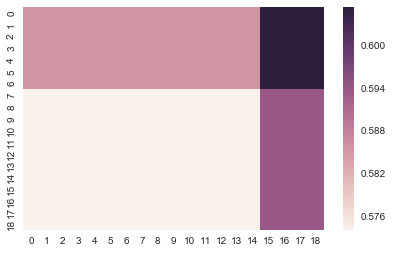

In [419]:
sns.heatmap(pd.DataFrame(pp_matrix))

In [408]:
var1 = 'lex_diversity'
var2 = 'foreign_word'
var3= 'noun_prop_pural'
var4 = 'verb.body'

percentiles = range(2,100,3)

#lex_ds = np.percentile([0,1], percentiles)
#foreign = np.percentile([0,1], percentiles)
lex_ds = np.percentile(X_rm[var1].values, percentiles)
foreign = np.percentile(X_rm[var2].values, percentiles)
noun_prop = np.percentile(X_rm[var3].values, percentiles)
vbody = np.percentile(X_rm[var2].values, percentiles)
weather = np.percentile(X_rm['verb.weather'].values, percentiles)

avg_row = pd.DataFrame(X_sf.mean(axis=0)).T

pp_matrix = np.zeros((33,33))

avg_row = pd.DataFrame(X_sf.mean(axis=0)).T
graph=pd.DataFrame({'x': 0, 'y': 0},index=[0])
for row, s in enumerate(lex_ds):
    #for col, p in enumerate(vbody):
        avg_row.loc[:,var1] = s
        avg_row.loc[:,var2] = p
        pred_prob = rfc_best_sf.predict_proba(avg_row.values)[:,1]
        graph.append([s,pred_prob[0]])
        pp_matrix[row, col] = pred_prob
        graph.ix[row,0] = s
        graph.ix[row,1] = pred_prob[0]


In [352]:
lex_ds

array([ 0.02,  0.05,  0.08,  0.11,  0.14,  0.17,  0.2 ,  0.23,  0.26,
        0.29,  0.32,  0.35,  0.38,  0.41,  0.44,  0.47,  0.5 ,  0.53,
        0.56,  0.59,  0.62,  0.65,  0.68,  0.71,  0.74,  0.77,  0.8 ,
        0.83,  0.86,  0.89,  0.92,  0.95,  0.98])

{'x', 'y'}

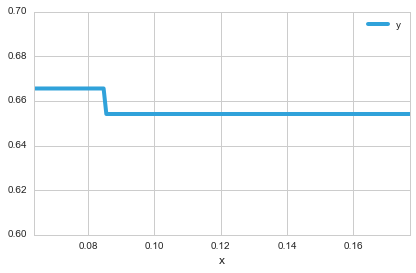

In [409]:
fig = plt.figure(figsize=(18,8))

sns.set_style("whitegrid")
graph.plot(kind='line',x='x', y='y', ylim=[.6,.7])
#plt.ylim([.5,.8])


In [330]:
percentiles = range(2,100,3)
#percentiles